In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import HARK.ConsumptionSaving.ConsIndShockModel as cism
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

In [3]:
cpm.init_portfolio

{'CRRA': 5.0,
 'Rfree': 1.03,
 'DiscFac': 0.9,
 'LivPrb': [0.98],
 'PermGroFac': [1.01],
 'BoroCnstArt': 0.0,
 'MaxKinks': 400,
 'AgentCount': 10000,
 'aNrmInitMean': 0.0,
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'PermGroFacAgg': 1.0,
 'T_age': None,
 'T_cycle': 1,
 'aXtraMin': 0.001,
 'aXtraMax': 100,
 'aXtraNestFac': 1,
 'aXtraCount': 200,
 'aXtraExtra': [None],
 'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7,
 'UnempPrb': 0.05,
 'UnempPrbRet': 0.005,
 'IncUnemp': 0.3,
 'IncUnempRet': 0.0,
 'tax_rate': 0.0,
 'T_retire': 0,
 'vFuncBool': False,
 'CubicBool': False,
 'RiskyAvg': 1.08,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25,
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

This is what it looks like when it's put all together.

## Integrating with the Liquidity Model

To integrate with the LiquidityModel in NetLogo, we need code that:

- Collects price data from the LiquidityModel
- Inputs this data to the consumer agents, which then compute their demand for the risky asset
- Aggregates the consumer demand.



### Initialize the agents to start

This is to set up the agent parameters and quantities used in the simulation.

In [4]:
## List of tuples: 
##  ( parameters, 
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    ({'CRRA': 5.0}, 100, (0.08, 800, 9200)), # Normal consumers
    ({'CRRA': 6.0}, 50,  (0.08, 800, 9200)),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  (0.08, 800, 9200))  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'AdjustPrb' : 0.0,
    'aNrmInitMean' : 1.0,
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0,
    'pLvlInitStd' : 0.0
}

In [5]:

agents = hpa.create_agents(agent_classes, ap)

# Initialize with Share values.

for agent in agents:
    # allow adjustment in the first round
    agent.AdjustPrb = 1.0
    agent.T_sim = 1
    agent.solve()
    agent.initializeSim()
    agent.simulate()
    
    #change it back
    agent.AdjustPrb = 0.0

#### Test agent

This is a test agent used to test and demonstrate the functions below.

In [6]:
# test agent
agent = cpm.PortfolioConsumerType(
    AgentCount = 3,
    **ap
)
agent.solve()
agent.T_sim = 100
agent.track_vars += ['pLvlNow','mNrmNow','ShareNow','RiskyNow']
agent.initializeSim()
agent.simulate()

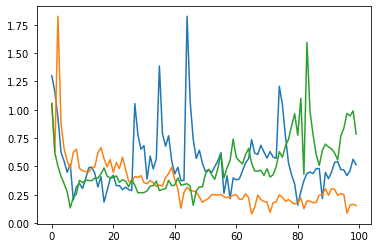

In [7]:
plt.plot(agent.history['mNrmNow'] / agent.history['pLvlNow'])

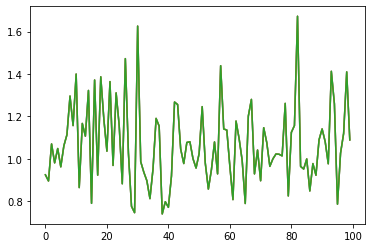

In [8]:
plt.plot(agent.history['RiskyNow'])

The normalize market assets of each agent at the current (final) stage of the simulation.

In [9]:
agent.mNrmNow

array([1.43496952, 1.26662069, 1.18563362])

The function from normalized market assets to the proportion of assets allocated to the risky share.

In [10]:
agent.solution[0].ShareFuncAdj

### Synthetic price data

In the future, get this from the LiquidityModel.

For now, just use any array of prices with noise and drift.

In [11]:
init_prices = np.ones(1)

In [12]:
return_rate = .05
time_steps = 1000

def random_prices(return_rate = return_rate, time_steps = time_steps):
    prices = np.random.random(
        time_steps
    ) + np.arange(0,
                  return_rate,return_rate / time_steps)
    
    return prices

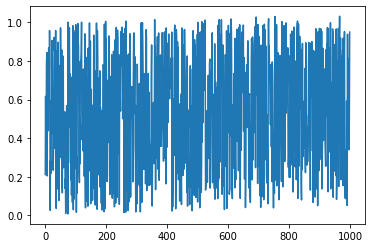

In [13]:
prices = random_prices()

plt.plot(prices)

### Agents estimate return rate and volatility from historical data

The agents look at the most recent historical price data to form their expectations of the future.

This is a very simplified version of what could later be better specified in line with _adaptive expectations_:

https://en.wikipedia.org/wiki/Adaptive_expectations

### Trying again

In [14]:
print(agent.RiskyStd, agent.mNrmNow)

0.2 [1.43496952 1.26662069 1.18563362]


In [15]:
hpa.update_agent(agent, agent.history['ShareNow'][0], prices)

In [16]:
agent.RiskyStd

0.29355533819130164

In [17]:
print(agent.RiskyStd, agent.mNrmNow)

0.29355533819130164 [0.18434776 0.01857818 0.51930545]


### Demand function for the intermittent demand problem

In the intermittent demand problem, consumers take their current state and determine risky porfolio share of their assets to invest.

The agent responds to the price history by:
 - updating their current assets
 - updating their expectations of the risky asset
 - returning their risky share allocation.

Other aspects of the problem are fixed for now.

In [18]:
d = hpa.demand(agent, prices)

### Putting it all together

Each agent knows their old risky allocation, old risk free allocation, and the prices of the last quarter.

They computer their new market assets and then their new demand.

In [22]:
init_demands = [hpa.demand(agent, init_prices) for agent in agents]
d = [hpa.demand(agent, prices) for agent in agents]

In [23]:
hpa.aggregate_buy_and_sell(init_demands, d)

(20.692233866377777, 0)